In [81]:
import os
import sys
import pandas
from tqdm import tqdm
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [82]:
from torch.utils.data import DataLoader, Dataset
from torch.nn import modules
from torch import nn
import torch
from torchsummaryX import summary
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from skorch import NeuralNet
import skorch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [70]:
from bsa.dataset.data_loader import load_raw_data, preprocess_data, splitting_function

In [71]:
import random

seed = 3407
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# torch.use_deterministic_algorithms(True)

if device == 'cuda':
    torch.backends.cudnn.deterministic = True

# Configurations

# Dataset

In [72]:
raw_data, raw_labels = load_raw_data("../data/data_for_bankruptcy_prediction_no_lags_corrected.csv")
x, y = preprocess_data(raw_data, raw_labels, horizon=2)
x_train, x_test, y_train, y_test = splitting_function(x, y, 0.5)
x_val, x_test, y_val, y_test = splitting_function(x_test, y_test, 0.5)

/home/tonyzou/bankruptcy-survival-analysis/bsa/dataset/data_loader.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['HBankrupt'] = ((y['T'] <= (horizon + 1)) & bankrupted_filter).astype(int)


In [73]:
# Verify
print("Training features shape: ", x_train.shape)
print("Training labels shape: ", y_train.shape)
print("Testing features shape: ", x_test.shape)
print("Testing labels shape: ", y_test.shape)
print("Validation features shape: ", x_val.shape)
print("Validation labels shape: ", y_val.shape)

Training features shape:  (33219, 324)
Training labels shape:  (33219, 4)
Testing features shape:  (16871, 324)
Testing labels shape:  (16871, 4)
Validation features shape:  (16155, 324)
Validation labels shape:  (16155, 4)


In [74]:
# Sanity check: if gv_keys are leaked
assert len(np.intersect1d(x_train.index.get_level_values(0).values, x_test.index.get_level_values(0).values)) == 0
assert len(np.intersect1d(x_train.index.get_level_values(0).values, x_val.index.get_level_values(0).values)) == 0
assert len(np.intersect1d(x_test.index.get_level_values(0).values, x_val.index.get_level_values(0).values)) == 0

# Network

In [75]:
class MLP(torch.nn.Module):
    def __init__(self, input_feature, layer_size, num_layers, activation, dropout_rate) -> None:
        torch.manual_seed(seed)
        
        super().__init__()

        blocks = [
            nn.Sequential(
                nn.Linear(layer_size if i > 0 else input_feature, layer_size),
                nn.BatchNorm1d(layer_size),
                activation(),
                nn.Dropout(dropout_rate)
            )
            for i in range(num_layers)
        ]

        self.layers = nn.Sequential(
            *blocks,
            nn.Linear(layer_size, 1),
        )

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.layers.apply(init_weights)

    def forward(self, x):
        return self.layers(x)

In [76]:
x_train_mlp = torch.tensor(x_train.values, dtype=torch.float32)
y_train_mlp = torch.tensor(y_train.values[:, 3], dtype=torch.float32).unsqueeze(1)

x_test_mlp = torch.tensor(x_test.values, dtype=torch.float32)
y_test_mlp = torch.tensor(y_test.values[:, 3], dtype=torch.float32).unsqueeze(1)

x_val_mlp = torch.tensor(x_val.values, dtype=torch.float32)
y_val_mlp = torch.tensor(y_val.values[:, 3], dtype=torch.float32).unsqueeze(1)

In [78]:
cv = [(np.arange(0, x_train_mlp.shape[0]), np.arange(x_train_mlp.shape[0], x_train_mlp.shape[0] + x_val_mlp.shape[0]))]
X = torch.cat((x_train_mlp, x_val_mlp), dim=0)
Y = torch.cat((y_train_mlp, y_val_mlp), dim=0)

In [55]:
from copy import deepcopy

class CheckpointCallback(skorch.callbacks.Callback):
    def on_epoch_end(self, net, **kwargs):
        net.history.record('checkpoint', deepcopy(net.module_.state_dict()))

In [56]:
skorch_net = NeuralNet(
    MLP,
    module__input_feature=x_train.shape[1],
    module__layer_size=64,
    module__num_layers=1,
    module__activation=nn.Sigmoid,
    module__dropout_rate=0.2,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.AdamW,
    optimizer__lr=0.001,
    optimizer__weight_decay=0.01,
    max_epochs=100,
    batch_size=256,
    device=device,
    train_split=skorch.dataset.ValidSplit(cv=cv),
    # verbose=0,
    callbacks=[
        ('early_stopping', skorch.callbacks.EarlyStopping('valid_loss')),
        ('checkpoint', CheckpointCallback),
    ],
)

In [57]:
grid_params = {
    'module__layer_size': [16, 32, 64],
    'module__num_layers': [1, 2, 3],
    'module__dropout_rate': [0.0, 0.1, 0.2],
    'module__activation': [nn.ReLU, nn.LeakyReLU, nn.GELU, nn.Tanh, nn.Sigmoid, nn.SELU],
    'max_epochs': [100],
    'batch_size': [256]
}

In [58]:
skorch_net.fit(X, Y)

  epoch                                                                                                                                                                                                  checkpoint    train_loss    valid_loss     dur
-------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  ------------  ------------  ------
                                                                                                                                         device='cuda:0')), ('layers.1.bias', tensor([-0.0700], device='cuda:0'))])
                                                                                                                                         device='cuda:0')), ('layers.1.bias', tensor([-0.0949], device='cuda:0'))])
                                                                                

<class 'skorch.net.NeuralNet'>[initialized](
  module_=MLP(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=324, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Sigmoid()
        (3): Dropout(p=0.2, inplace=False)
      )
      (1): Linear(in_features=64, out_features=1, bias=True)
    )
  ),
)

In [61]:
skorch_net.history[-6, 'valid_loss']
# skorch_net.history[-6, 'checkpoint']

0.08705914950638742

In [62]:
skorch_net.module_.load_state_dict(skorch_net.history[-6, 'checkpoint'])

<All keys matched successfully>

In [63]:
skorch_net.module_.eval()
pred = skorch_net.module_(x_val_mlp.to(device))

In [64]:
skorch_net.criterion_(pred, y_val_mlp.to(device))

tensor(0.0871, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [19]:
from itertools import product
trial_params = [dict(zip(grid_params, v)) for v in product(*grid_params.values())]

In [20]:
from tqdm import tqdm

loss = 100

for params in tqdm(trial_params):
    skorch_net.set_params(**params)
    if skorch_net.history is not None:
        skorch_net.history.clear()
    skorch_net.fit(X, Y)
    history = skorch_net.history
    if(len(history)) < 100:
        cur_loss = skorch_net.history[-6]['valid_loss']
        epoch = len(history) - 5
    else:
        cur_loss = skorch_net.history[-6]['valid_loss']
        epoch = len(history)

    if cur_loss < loss:
        loss = cur_loss
        best_params = params
        best_epoch = epoch
        print("Best loss: {cur_loss}; params: {params}; epoch: {epoch}".format(cur_loss=cur_loss, params=params, epoch=epoch))

  1%|          | 1/162 [00:03<09:56,  3.71s/it]

Best loss: 0.1533940135944124; params: {'module__layer_size': 16, 'module__num_layers': 1, 'module__dropout_rate': 0.0, 'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'max_epochs': 100, 'batch_size': 256}; epoch: 13


  2%|▏         | 4/162 [00:12<08:13,  3.13s/it]


IndexError: list index out of range

In [15]:
best_params['verbose'] = 1
best_params['max_epochs'] = best_epoch
skorch_net.set_params(**best_params)
skorch_net.fit(X, Y)

Re-initializing module because the following parameters were re-set: module__activation, module__dropout_rate, module__layer_size, module__num_layers.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: activation, dropout_rate, input_feature, layer_size, num_layers.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4452        0.2212  0.1847
      2        0.2097        0.1746  0.1678
      3        0.1880        0.1651  0.1737
      4        0.1813        0.1616  0.1693
      5        0.1780        0.1597  0.2202
      6        0.1755        0.1587  0.1596
      7        0.1745        0.1578  0.1628
      8        0.1724        0.1569  0.1671
      9        0.1710        0.1562  0.1601
     10        0.1700        0.1558  0.1657
     11        0.1684        0.1553  0.1711
     12        0.1670        0.1548

<class 'skorch.net.NeuralNet'>[initialized](
  module_=MLP(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=324, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Sigmoid()
        (3): Dropout(p=0.2, inplace=False)
      )
      (1): Linear(in_features=64, out_features=1, bias=True)
    )
  ),
)

## EVALUATION

In [28]:
def predict_model(model, x):
    model.eval()
    return model.forward(x)[:, 0].cpu().detach().numpy()

In [27]:
predict_mlp_test = predict_model(skorch_net.module_, x_test_mlp.to(device))
predict_mlp_train = predict_model(skorch_net.module_, x_train_mlp.to(device))
predict_mlp_val = predict_model(skorch_net.module_, x_val_mlp.to(device))

# Logistics Regression

In [10]:
x_train_ml = x_train.values
y_train_ml = y_train.values[:, 3]

x_val_ml = x_val.values
y_val_ml = y_val.values[:, 3]

x_test_ml = x_test.values
y_test_ml = y_test.values[:, 3]

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

best_loss = 100
best_mod_lr = None

for alpha in [1, 0.1, 0.001, 0.0001, 0.00001]:
    clf = SGDClassifier(max_iter=10000, random_state=seed, loss='log_loss', n_jobs=-1, alpha=alpha)
    clf.fit(x_train_ml, y_train_ml) 
    y_pred_val = clf.predict(x_val_ml)
    loss = log_loss(y_val_ml, y_pred_val)
    if loss < best_loss:
        best_alpha = alpha
        best_loss = loss
        best_mod_lr = clf
    print("loss: {}".format(loss))

loss: 0.9683036565073876
loss: 0.9571480844278095
loss: 1.0307748601530256
loss: 1.2985085900629023
loss: 1.4769977433361536


In [13]:
clf = SGDClassifier(max_iter=10000, random_state=seed, loss='log_loss', n_jobs=-1, alpha=best_alpha)
clf.fit(x_train_ml, y_train_ml) 

SGDClassifier(alpha=0.1, loss='log_loss', max_iter=10000, n_jobs=-1,
              random_state=3407)

In [14]:
predict_lr_test = clf.predict_proba(x_test_ml)
predict_lr_train = clf.predict_proba(x_train_ml)
predict_lr_val = clf.predict_proba(x_val_ml)

# RandomForest

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
best_loss = 100

for max_depth in [5, 6]:
    for n_estimators in [50, 100, 200]:
        for max_features in [None, "sqrt", 50, 75]:
            rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, max_depth=max_depth, max_features=max_features, random_state=seed)
            rf.fit(x_train_ml, y_train_ml)
            y_pred_val = rf.predict_proba(x_val_ml)
            loss = log_loss(y_val_ml, y_pred_val)
            if(loss < best_loss):
                best_loss = loss
                best_max_depth = max_depth
                best_n_est = n_estimators
                best_max_features = max_features
                print("loss: {}, max_depth: {}, n_est: {}, max_feat: {}".format(loss, max_depth, n_estimators, max_features))

loss: 1.8952610452328489, max_depth: 5, n_est: 50, max_feat: None
loss: 1.8868376628095918, max_depth: 5, n_est: 50, max_feat: sqrt
loss: 1.8699908979630775, max_depth: 5, n_est: 50, max_feat: 50


In [24]:
rf = RandomForestClassifier(n_estimators=best_n_est, n_jobs=-1, max_depth=best_max_depth, max_features=best_max_features, random_state=seed)
rf.fit(x_train_ml, y_train_ml)

RandomForestClassifier(max_depth=5, max_features=50, n_estimators=50, n_jobs=-1,
                       random_state=3407)

In [25]:
predict_rf_val = rf.predict_proba(x_val)
predict_rf_train = rf.predict_proba(x_train_ml)
predict_rf_test = rf.predict_proba(x_test_ml)

/home/tonyzou/anaconda3/envs/torch-2.0/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# Graphs

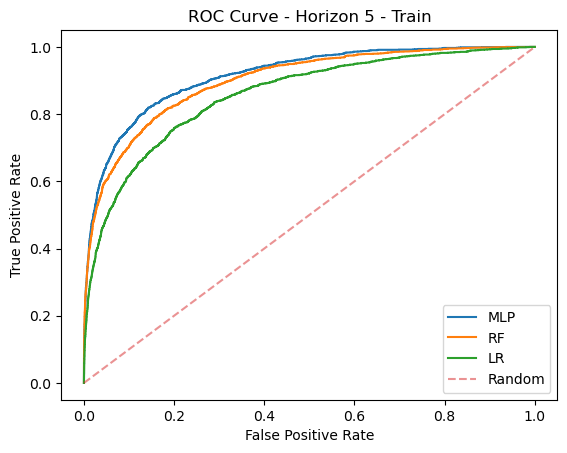

In [29]:
fpr_mlp, tpr_mlp, thresholds = roc_curve(y_train.values[:, 3], predict_mlp_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train.values[:, 3], predict_rf_train[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_train.values[:, 3], predict_lr_train[:, 1])

plt.plot(fpr_mlp, tpr_mlp, label='MLP')
plt.plot(fpr_rf, tpr_rf, label=f'RF')
plt.plot(fpr_lr, tpr_lr, label=f'LR')

plt.plot([0, 1], [0, 1], linestyle='--', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Horizon 5 - Train')
plt.legend()
# plt.xscale('log')
plt.show()

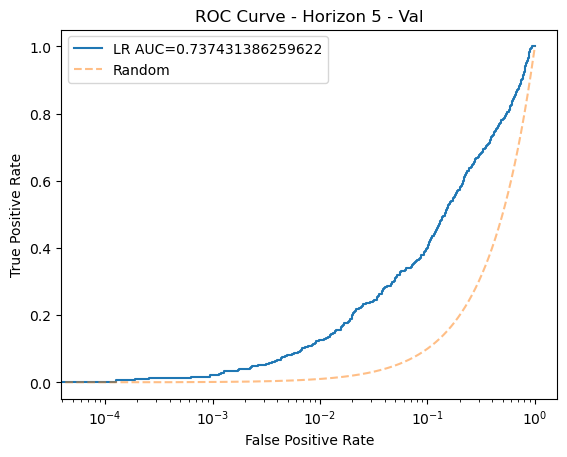

In [15]:
fpr_mlp, tpr_mlp, thresholds = roc_curve(y_val.values[:, 3], predict_mlp_val)
fpr_rf, tpr_rf, _ = roc_curve(y_val.values[:, 3], predict_rf_val[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_val.values[:, 3], predict_lr_val[:, 1])

mlp_auc = roc_auc_score(y_val.values[:, 3], predict_mlp_val)
rf_auc = roc_auc_score(y_val.values[:, 3], predict_rf_val[:, 1])
lr_auc = roc_auc_score(y_val.values[:, 3], predict_lr_val[:, 1])

plt.plot(fpr_mlp, tpr_mlp, label=f'MLP AUC={mlp_auc}')
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC={rf_auc}')
plt.plot(fpr_lr, tpr_lr, label=f'LR AUC={lr_auc}')

plt.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), linestyle='--', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Horizon 5 - Val')
plt.legend()
plt.xscale('log')
plt.show()

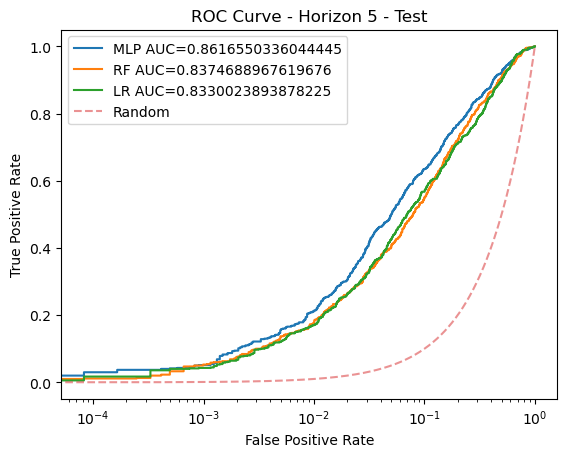

In [31]:
fpr_mlp, tpr_mlp, thresholds = roc_curve(y_test.values[:, 3], predict_mlp_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test.values[:, 3], predict_rf_test[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_test.values[:, 3], predict_lr_test[:, 1])

mlp_auc = roc_auc_score(y_test.values[:, 3], predict_mlp_test)
rf_auc = roc_auc_score(y_test.values[:, 3], predict_rf_test[:, 1])
lr_auc = roc_auc_score(y_test.values[:, 3], predict_lr_test[:, 1])

plt.plot(fpr_mlp, tpr_mlp, label=f'MLP AUC={mlp_auc}')
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC={rf_auc}')
plt.plot(fpr_lr, tpr_lr, label=f'LR AUC={lr_auc}')

plt.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), linestyle='--', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Horizon 5 - Test')
plt.legend()
plt.xscale('log')
plt.show()